In [1]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
!nvidia-smi
!pip install wandb 

Fri Oct 31 19:36:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GB10                    On  |   0000000F:01:00.0 Off |                  N/A |
| N/A   47C    P8              4W /  N/A  | Not Supported          |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If you are running this tutorial on Windows or MacOS and encounter aBrokenPipeError or RuntimeError related to multiprocessing, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>

</div>



In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Converts a PIL Image or numpy.ndarray to a PyTorch Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalizes a tensor image with mean and standard deviation.

batch_size = 4 # Define the batch size for the data loaders

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, # Load the CIFAR10 training dataset
                                        download=True, transform=transform) # Download the dataset if not already present and apply the defined transformations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # Create a DataLoader for the training dataset
                                          shuffle=True, num_workers=2) # Shuffle the data and use 2 worker processes for loading

testset = torchvision.datasets.CIFAR10(root='./data', train=False, # Load the CIFAR10 test dataset
                                       download=True, transform=transform) # Download the dataset if not already present and apply the defined transformations
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, # Create a DataLoader for the test dataset
                                         shuffle=False, num_workers=2) # Do not shuffle the test data and use 2 worker processes for loading

classes = ('plane', 'car', 'bird', 'cat', # Define the class names in the CIFAR10 dataset
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 33.2MB/s] 


Let us show some of the training images, for fun.


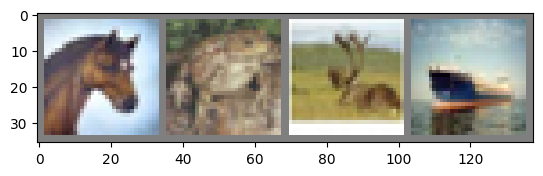

horse frog  deer  ship 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Define a Convolutional Neural Network
========================================


In [3]:
"""
CNN Training Framework with Performance Monitoring
Author: Hochan Son
Course: STATS 413 HW3

This module provides a structured framework for training CNN models on CIFAR-10
with built-in performance metrics monitoring and logging to Weights & Biases.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from typing import Dict, List, Tuple, Optional
import time
from dataclasses import dataclass, field
import wandb

@dataclass
class TrainingConfig:
    """Configuration class for training hyperparameters."""
    learning_rate: float = 0.001
    momentum: float = 0.9
    epochs: int = 20
    batch_size: int = 4
    num_workers: int = 2
    device: str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    log_interval: int = 2000


class PerformanceMetrics:
    """Base class for monitoring and logging performance metrics during training."""

    def __init__(self, model_name: str):
        """
        Initialize performance metrics tracker.

        Args:
            model_name: Name identifier for the model
        """
        self.model_name = model_name
        self.training_losses: List[float] = []
        self.epoch_times: List[float] = []
        self.test_accuracy: Optional[float] = None
        self.class_accuracies: Dict[str, float] = {}
        self.start_time: Optional[float] = None
        self.total_training_time: float = 0.0

    def start_epoch_timer(self):
        """Start timer for epoch duration tracking."""
        self.start_time = time.time()

    def end_epoch_timer(self) -> float:
        """End timer and record epoch duration."""
        if self.start_time is None:
            return 0.0
        elapsed = time.time() - self.start_time
        self.epoch_times.append(elapsed)
        self.total_training_time += elapsed
        self.start_time = None
        return elapsed

    def log_training_loss(self, loss: float, step: int):
        """
        Log training loss.

        Args:
            loss: Loss value to log
            step: Current training step
        """
        self.training_losses.append(loss)
        if wandb.run is not None:
            wandb.log({f"{self.model_name}/training_loss": loss}, step=step)

    def log_test_results(self, overall_accuracy: float, class_accuracies: Dict[str, float]):
        """
        Log test evaluation results.

        Args:
            overall_accuracy: Overall test accuracy percentage
            class_accuracies: Per-class accuracy percentages
        """
        self.test_accuracy = overall_accuracy
        self.class_accuracies = class_accuracies

        if wandb.run is not None:
            wandb.log({
                f"{self.model_name}/test_overall_accuracy": overall_accuracy,
                f"{self.model_name}/total_training_time": self.total_training_time
            })

            for classname, accuracy in class_accuracies.items():
                wandb.log({f"{self.model_name}/test_accuracy_{classname}": accuracy})

    def print_summary(self):
        """Print a summary of all collected metrics."""
        print(f"\n{'='*60}")
        print(f"Performance Summary for {self.model_name}")
        print(f"{'='*60}")
        print(f"Total Training Time: {self.total_training_time:.2f} seconds")
        print(f"Average Epoch Time: {sum(self.epoch_times)/len(self.epoch_times):.2f} seconds")
        print(f"Overall Test Accuracy: {self.test_accuracy:.2f}%")
        print(f"\nPer-Class Accuracies:")
        for classname, accuracy in self.class_accuracies.items():
            print(f"  {classname:10s}: {accuracy:5.1f}%")
        print(f"{'='*60}\n")


class CNNModel(nn.Module):
    """Base class for CNN models with integrated performance monitoring."""

    def __init__(self, model_name: str):
        """
        Initialize CNN model.

        Args:
            model_name: Name identifier for the model
        """
        super().__init__()
        self.model_name = model_name
        self.metrics = PerformanceMetrics(model_name)

    def get_optimizer(self, config: TrainingConfig) -> optim.Optimizer:
        """
        Get optimizer for training. Can be overridden by subclasses.

        Args:
            config: Training configuration

        Returns:
            PyTorch optimizer instance
        """
        return optim.SGD(self.parameters(), lr=config.learning_rate, momentum=config.momentum)

    def train_model(self, trainloader, config: TrainingConfig, criterion):
        """
        Train the model on the training dataset.

        Args:
            trainloader: DataLoader for training data
            config: Training configuration
            criterion: Loss function
        """
        optimizer = self.get_optimizer(config)
        device = torch.device(config.device)
        self.to(device)

        print(f"\nTraining {self.model_name}...")
        print(f"{'='*60}")

        for epoch in range(config.epochs):
            self.metrics.start_epoch_timer()
            running_loss = 0.0

            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % config.log_interval == (config.log_interval - 1):
                    avg_loss = running_loss / config.log_interval
                    step = epoch * len(trainloader) + i
                    print(f'[Epoch {epoch + 1:2d}, Batch {i + 1:5d}] loss: {avg_loss:.3f}')
                    self.metrics.log_training_loss(avg_loss, step)
                    running_loss = 0.0

            epoch_time = self.metrics.end_epoch_timer()
            print(f'Epoch {epoch + 1} completed in {epoch_time:.2f} seconds')

        print(f'Finished Training {self.model_name}')

    def evaluate_model(self, testloader, classes: Tuple[str, ...], config: TrainingConfig):
        """
        Evaluate the model on the test dataset.

        Args:
            testloader: DataLoader for test data
            classes: Tuple of class names
            config: Training configuration
        """
        device = torch.device(config.device)
        self.to(device)
        self.eval()

        print(f"\nEvaluating {self.model_name}...")

        # Overall accuracy
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        overall_accuracy = 100 * correct / total

        # Per-class accuracy
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}

        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = self(images)
                _, predictions = torch.max(outputs, 1)

                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1

        class_accuracies = {
            classname: 100 * float(correct_pred[classname]) / total_pred[classname]
            for classname in classes
        }

        self.metrics.log_test_results(overall_accuracy, class_accuracies)
        self.metrics.print_summary()

    def save_model(self, path: str):
        """
        Save model state dictionary.

        Args:
            path: File path to save the model
        """
        torch.save(self.state_dict(), path)
        print(f"Model {self.model_name} saved to {path}")


class OriginalNet(CNNModel):
    """Original baseline CNN architecture."""

    def __init__(self):
        super().__init__(model_name="OriginalNet")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DoubleNet_1(CNNModel):
    """CNN with doubled channel dimensions."""

    def __init__(self):
        super().__init__(model_name="DoubleNet_1")
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 168)
        self.fc3 = nn.Linear(168, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DoubleNet_2(CNNModel):
    """CNN with doubled channels and additional convolutional layer."""

    def __init__(self):
        super().__init__(model_name="DoubleNet_2")
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        # After conv1 (32->28) + pool (28->14)
        # After conv2 (14->10) + pool (10->5)
        # Shape is 32 * 5 * 5 = 800
        self.fc1 = nn.Linear(32 * 5 * 5, 240)
        self.fc2 = nn.Linear(240, 168)
        self.fc3 = nn.Linear(168, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Note: conv3 is defined but not used in forward pass to match original notebook
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_optimizer(self, config: TrainingConfig) -> optim.Optimizer:
        """Override to use AdamW optimizer instead of SGD."""
        return optim.AdamW(self.parameters(), lr=config.learning_rate)

In [ ]:
import torch

def prepare_data(config: TrainingConfig) -> Tuple[torch.utils.data.DataLoader,
                                                    torch.utils.data.DataLoader,
                                                    Tuple[str, ...]]:
    """
    Prepare CIFAR-10 data loaders and class names.

    Args:
        config: Training configuration

    Returns:
        Tuple of (trainloader, testloader, classes)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

def main():
    """Main function to orchestrate model training and evaluation."""

    # Initialize configuration
    config = TrainingConfig(
        learning_rate=0.001,
        momentum=0.9,
        epochs=20,
        batch_size=4,
        num_workers=2
    )

    # Initialize wandb
    wandb.init(
        project="STATS413_HW3",
        #api_key="13d55e02e607f6f881f5e8cecfe06fd17a7dc672",
        entity="ohsono-ucla",
        config={
            "learning_rate": config.learning_rate,
            "momentum": config.momentum,
            "epochs": config.epochs,
            "batch_size": config.batch_size
        }
    )

    # Check device
    device = torch.device(config.device)
    print(f"Using device: {device}")

    # Prepare data
    print("Preparing data...")
    trainloader, testloader, classes = prepare_data(config)
    print(f"Data loaded successfully. Training samples: {len(trainloader.dataset)}, "
          f"Test samples: {len(testloader.dataset)}")

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize models
    models = [
        # OriginalNet(),
         DoubleNet_1(),
        #DoubleNet_2()
    ]

    # Train and evaluate each model
    for model in models:
        print(f"\n{'#'*60}")
        print(f"Processing Model: {model.model_name}")
        print(f"{'#'*60}")

        # Train
        model.train_model(trainloader, config, criterion)

        # Save model
        save_path = f'./data/cifar_{model.model_name}.pth'
        model.save_model(save_path)

        # Evaluate
        model.evaluate_model(testloader, classes, config)

    # Final summary
    print(f"\n{'#'*60}")
    print("All models trained and evaluated successfully!")
    print(f"{'#'*60}")

    # Close wandb
    wandb.finish()


if __name__ == "__main__":
    main()


### LeakyReLUnet / TanhNet / ResidualBlock / ResNet
1) LeakyReLUNet: CNN architecture with LeakyReLU activation
2) TanhNet: CNN architecture with Tanh activation
3) ResidualBlock: Residual block with identity connection
4) ResNet: ResNet architecture with residual blocks for CIFAR-10.

In [7]:
class LeakyReLUNet(CNNModel):
    """CNN architecture with LeakyReLU activation."""

    def __init__(self):
        super().__init__(model_name="CNN_LeakyReLU")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


class TanhNet(CNNModel):
    """CNN architecture with Tanh activation."""

    def __init__(self):
        super().__init__(model_name="CNN_Tanh")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class ResidualBlock(nn.Module):
    """
    Residual block with identity connection.
    
    Architecture:
    - Conv2d -> BatchNorm -> ReLU -> Conv2d -> BatchNorm
    - Skip connection (with 1x1 conv if channels change)
    - Final ReLU after adding residual
    """
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        """
        Initialize residual block.
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            stride: Stride for convolution (used for downsampling)
        """
        super().__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Use 1x1 conv to match dimensions
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += identity  # Add skip connection
        out = F.relu(out)
        
        return out


class ResNet(CNNModel):
    """
    ResNet architecture with residual blocks for CIFAR-10.
    
    Network structure:
    - Initial conv layer (3x32x32 -> 16x32x32)
    - Residual block 1 (16x32x32 -> 32x16x16) with stride=2
    - Residual block 2 (32x16x16 -> 64x8x8) with stride=2
    - Residual block 3 (64x8x8 -> 64x8x8)
    - Average pooling -> FC layer
    
    This design uses fewer parameters than very deep ResNets but
    demonstrates the residual connection concept.
    """
    
    def __init__(self):
        super().__init__(model_name="ResNet_Custom")
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Residual blocks
        self.layer1 = ResidualBlock(16, 32, stride=2)  # Downsample
        self.layer2 = ResidualBlock(32, 64, stride=2)  # Downsample
        self.layer3 = ResidualBlock(64, 64, stride=1)  # Same size
        
        # Global average pooling and FC
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)
    
    def forward(self, x):
        # Initial conv
        x = F.relu(self.bn1(self.conv1(x)))
        
        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and FC
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [9]:
import torch

def prepare_data(config: TrainingConfig) -> Tuple[torch.utils.data.DataLoader,
                                                    torch.utils.data.DataLoader,
                                                    Tuple[str, ...]]:
    """
    Prepare CIFAR-10 data loaders and class names.

    Args:
        config: Training configuration

    Returns:
        Tuple of (trainloader, testloader, classes)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers
    )

    testset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers
    )

    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

def main_activation_comparison():
    """
    Main function to compare different activation functions.
    
    This function trains and evaluates three CNN models with different
    activation functions:
    - ReLU (baseline from tutorial)
    - LeakyReLU (with negative slope of 0.01)
    - Tanh
    
    All models have identical architecture except for the activation function.
    """
    
    # Initialize configuration
    config = TrainingConfig(
        learning_rate=0.001,
        momentum=0.9,
        epochs=20,
        batch_size=4,
        num_workers=2
    )

    # Initialize wandb
    wandb.init(
        project="STATS413_HW3_Activations",
        entity="ohsono-ucla",
        config={
            "learning_rate": config.learning_rate,
            "momentum": config.momentum,
            "epochs": config.epochs,
            "batch_size": config.batch_size,
            "experiment": "activation_comparison"
        }
    )

    # Check device
    device = torch.device(config.device)
    print(f"Using device: {device}")

    # Prepare data
    print("Preparing data...")
    trainloader, testloader, classes = prepare_data(config)
    print(f"Data loaded successfully. Training samples: {len(trainloader.dataset)}, "
          f"Test samples: {len(testloader.dataset)}")

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize models with different activation functions
    models = [
        OriginalNet(),      # ReLU
        LeakyReLUNet(),     # LeakyReLU
        TanhNet()           # Tanh
    ]

    print("\n" + "="*80)
    print("EXPERIMENT: Comparing Different Activation Functions")
    print("="*80)
    print("\nModels to compare:")
    print("1. OriginalNet_ReLU: Baseline with ReLU activation")
    print("2. CNN_LeakyReLU: LeakyReLU with negative_slope=0.01")
    print("3. CNN_Tanh: Tanh activation")
    print("\nAll models use the same architecture (conv-pool-conv-pool-fc-fc-fc)")
    print("="*80 + "\n")

    # Train and evaluate each model
    results = []
    for model in models:
        print(f"\n{'#'*80}")
        print(f"Processing Model: {model.model_name}")
        print(f"{'#'*80}")

        # Train
        model.train_model(trainloader, config, criterion)

        # Save model
        save_path = f'./data/cifar_{model.model_name}.pth'
        model.save_model(save_path)

        # Evaluate
        model.evaluate_model(testloader, classes, config)
        
        # Store results for comparison
        results.append({
            'name': model.model_name,
            'accuracy': model.metrics.test_accuracy,
            'training_time': model.metrics.total_training_time
        })

    # Print comparison summary
    print(f"\n{'='*80}")
    print("ACTIVATION FUNCTION COMPARISON SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<25} {'Test Accuracy':<20} {'Training Time (s)':<20}")
    print(f"{'-'*80}")
    for result in results:
        print(f"{result['name']:<25} {result['accuracy']:>6.2f}%{'':<13} {result['training_time']:>10.2f}")
    print(f"{'='*80}\n")

    # Close wandb
    wandb.finish()


if __name__=="__main__":
    main_activation_comparison()

Using device: cuda:0
Preparing data...
Data loaded successfully. Training samples: 50000, Test samples: 10000

EXPERIMENT: Comparing Different Activation Functions

Models to compare:
1. OriginalNet_ReLU: Baseline with ReLU activation
2. CNN_LeakyReLU: LeakyReLU with negative_slope=0.01
3. CNN_Tanh: Tanh activation

All models use the same architecture (conv-pool-conv-pool-fc-fc-fc)


################################################################################
Processing Model: OriginalNet
################################################################################

Training OriginalNet...
[Epoch  1, Batch  2000] loss: 2.160
[Epoch  1, Batch  4000] loss: 1.794
[Epoch  1, Batch  6000] loss: 1.673
[Epoch  1, Batch  8000] loss: 1.574
[Epoch  1, Batch 10000] loss: 1.509
[Epoch  1, Batch 12000] loss: 1.459
Epoch 1 completed in 32.65 seconds
[Epoch  2, Batch  2000] loss: 1.388
[Epoch  2, Batch  4000] loss: 1.385
[Epoch  2, Batch  6000] loss: 1.370
[Epoch  2, Batch  8000] loss: 1.312


wandb: WARNING Tried to log to step 1999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  1, Batch  4000] loss: 1.820
[Epoch  1, Batch  6000] loss: 1.640


wandb: WARNING Tried to log to step 3999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  1, Batch  8000] loss: 1.572


wandb: WARNING Tried to log to step 7999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  1, Batch 10000] loss: 1.512
[Epoch  1, Batch 12000] loss: 1.475
Epoch 1 completed in 37.99 seconds


wandb: WARNING Tried to log to step 9999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 11999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  2, Batch  2000] loss: 1.392
[Epoch  2, Batch  4000] loss: 1.378


wandb: WARNING Tried to log to step 14499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 16499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  2, Batch  6000] loss: 1.343


wandb: WARNING Tried to log to step 18499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  2, Batch  8000] loss: 1.325
[Epoch  2, Batch 10000] loss: 1.318
[Epoch  2, Batch 12000] loss: 1.299


wandb: WARNING Tried to log to step 20499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 22499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 24499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 2 completed in 32.27 seconds
[Epoch  3, Batch  2000] loss: 1.221
[Epoch  3, Batch  4000] loss: 1.215


wandb: WARNING Tried to log to step 26999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 28999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch  6000] loss: 1.220
[Epoch  3, Batch  8000] loss: 1.198


wandb: WARNING Tried to log to step 30999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 32999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch 10000] loss: 1.202


wandb: WARNING Tried to log to step 34999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch 12000] loss: 1.171
Epoch 3 completed in 37.63 seconds


wandb: WARNING Tried to log to step 36999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch  2000] loss: 1.097


wandb: WARNING Tried to log to step 39499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch  4000] loss: 1.118
[Epoch  4, Batch  6000] loss: 1.136


wandb: WARNING Tried to log to step 41499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 43499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch  8000] loss: 1.132
[Epoch  4, Batch 10000] loss: 1.111


wandb: WARNING Tried to log to step 45499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 47499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch 12000] loss: 1.101
Epoch 4 completed in 36.15 seconds
[Epoch  5, Batch  2000] loss: 1.018


wandb: WARNING Tried to log to step 49499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 51999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch  4000] loss: 1.047


wandb: WARNING Tried to log to step 53999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch  6000] loss: 1.048
[Epoch  5, Batch  8000] loss: 1.047


wandb: WARNING Tried to log to step 55999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 57999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch 10000] loss: 1.044


wandb: WARNING Tried to log to step 59999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch 12000] loss: 1.062
Epoch 5 completed in 41.48 seconds


wandb: WARNING Tried to log to step 61999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch  2000] loss: 0.960
[Epoch  6, Batch  4000] loss: 0.982


wandb: WARNING Tried to log to step 64499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 66499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch  6000] loss: 0.990
[Epoch  6, Batch  8000] loss: 0.971


wandb: WARNING Tried to log to step 68499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 70499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch 10000] loss: 1.015


wandb: WARNING Tried to log to step 72499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch 12000] loss: 0.984
Epoch 6 completed in 35.21 seconds
[Epoch  7, Batch  2000] loss: 0.881


wandb: WARNING Tried to log to step 74499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 76999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  7, Batch  4000] loss: 0.928
[Epoch  7, Batch  6000] loss: 0.947
[Epoch  7, Batch  8000] loss: 0.954


wandb: WARNING Tried to log to step 78999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 80999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 82999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  7, Batch 10000] loss: 0.962
[Epoch  7, Batch 12000] loss: 0.958
Epoch 7 completed in 27.02 seconds


wandb: WARNING Tried to log to step 84999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 86999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  8, Batch  2000] loss: 0.867
[Epoch  8, Batch  4000] loss: 0.873


wandb: WARNING Tried to log to step 89499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 91499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  8, Batch  6000] loss: 0.887
[Epoch  8, Batch  8000] loss: 0.907


wandb: WARNING Tried to log to step 93499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 95499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  8, Batch 10000] loss: 0.917
[Epoch  8, Batch 12000] loss: 0.908
Epoch 8 completed in 26.17 seconds
[Epoch  9, Batch  2000] loss: 0.808


wandb: WARNING Tried to log to step 97499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 99499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 101999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  9, Batch  4000] loss: 0.845
[Epoch  9, Batch  6000] loss: 0.868


wandb: WARNING Tried to log to step 103999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 105999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  9, Batch  8000] loss: 0.884
[Epoch  9, Batch 10000] loss: 0.893


wandb: WARNING Tried to log to step 107999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 109999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  9, Batch 12000] loss: 0.893
Epoch 9 completed in 30.46 seconds
[Epoch 10, Batch  2000] loss: 0.766


wandb: WARNING Tried to log to step 111999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 114499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 10, Batch  4000] loss: 0.804
[Epoch 10, Batch  6000] loss: 0.833


wandb: WARNING Tried to log to step 116499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 118499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 10, Batch  8000] loss: 0.845
[Epoch 10, Batch 10000] loss: 0.838


wandb: WARNING Tried to log to step 120499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 122499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 10, Batch 12000] loss: 0.862
Epoch 10 completed in 27.77 seconds
[Epoch 11, Batch  2000] loss: 0.770


wandb: WARNING Tried to log to step 124499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 126999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 11, Batch  4000] loss: 0.791
[Epoch 11, Batch  6000] loss: 0.792


wandb: WARNING Tried to log to step 128999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 130999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 11, Batch  8000] loss: 0.804
[Epoch 11, Batch 10000] loss: 0.821
[Epoch 11, Batch 12000] loss: 0.843
Epoch 11 completed in 26.37 seconds


wandb: WARNING Tried to log to step 132999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 134999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 136999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 12, Batch  2000] loss: 0.722
[Epoch 12, Batch  4000] loss: 0.758


wandb: WARNING Tried to log to step 139499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 141499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 12, Batch  6000] loss: 0.782
[Epoch 12, Batch  8000] loss: 0.787


wandb: WARNING Tried to log to step 143499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 145499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 12, Batch 10000] loss: 0.811
[Epoch 12, Batch 12000] loss: 0.807
Epoch 12 completed in 30.38 seconds


wandb: WARNING Tried to log to step 147499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 149499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch  2000] loss: 0.705
[Epoch 13, Batch  4000] loss: 0.726


wandb: WARNING Tried to log to step 151999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 153999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch  6000] loss: 0.762


wandb: WARNING Tried to log to step 155999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch  8000] loss: 0.799
[Epoch 13, Batch 10000] loss: 0.775


wandb: WARNING Tried to log to step 157999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 159999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch 12000] loss: 0.777
Epoch 13 completed in 35.91 seconds
[Epoch 14, Batch  2000] loss: 0.680


wandb: WARNING Tried to log to step 161999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 164499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch  4000] loss: 0.710
[Epoch 14, Batch  6000] loss: 0.735


wandb: WARNING Tried to log to step 166499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 168499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch  8000] loss: 0.742
[Epoch 14, Batch 10000] loss: 0.762


wandb: WARNING Tried to log to step 170499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 172499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch 12000] loss: 0.779
Epoch 14 completed in 28.84 seconds


wandb: WARNING Tried to log to step 174499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 176999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 15, Batch  2000] loss: 0.665
[Epoch 15, Batch  4000] loss: 0.711


wandb: WARNING Tried to log to step 178999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 180999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 15, Batch  6000] loss: 0.702
[Epoch 15, Batch  8000] loss: 0.730
[Epoch 15, Batch 10000] loss: 0.748
[Epoch 15, Batch 12000] loss: 0.747


wandb: WARNING Tried to log to step 182999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 184999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 186999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Epoch 15 completed in 26.35 seconds
[Epoch 16, Batch  2000] loss: 0.629


wandb: WARNING Tried to log to step 189499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 16, Batch  4000] loss: 0.673
[Epoch 16, Batch  6000] loss: 0.712


wandb: WARNING Tried to log to step 191499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 193499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 16, Batch  8000] loss: 0.718
[Epoch 16, Batch 10000] loss: 0.742


wandb: WARNING Tried to log to step 195499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 197499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 16, Batch 12000] loss: 0.758
Epoch 16 completed in 31.10 seconds
[Epoch 17, Batch  2000] loss: 0.623


wandb: WARNING Tried to log to step 199499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 201999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 17, Batch  4000] loss: 0.671
[Epoch 17, Batch  6000] loss: 0.692
[Epoch 17, Batch  8000] loss: 0.715


wandb: WARNING Tried to log to step 203999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 205999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 207999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 17, Batch 10000] loss: 0.714
[Epoch 17, Batch 12000] loss: 0.721
Epoch 17 completed in 23.22 seconds
[Epoch 18, Batch  2000] loss: 0.618


wandb: WARNING Tried to log to step 209999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 211999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 214499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 18, Batch  4000] loss: 0.637
[Epoch 18, Batch  6000] loss: 0.678
[Epoch 18, Batch  8000] loss: 0.700


wandb: WARNING Tried to log to step 216499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 218499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 220499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 18, Batch 10000] loss: 0.716


wandb: WARNING Tried to log to step 222499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 18, Batch 12000] loss: 0.720
Epoch 18 completed in 27.80 seconds
[Epoch 19, Batch  2000] loss: 0.594


wandb: WARNING Tried to log to step 224499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 226999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 19, Batch  4000] loss: 0.646
[Epoch 19, Batch  6000] loss: 0.660


wandb: WARNING Tried to log to step 228999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 230999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 19, Batch  8000] loss: 0.666
[Epoch 19, Batch 10000] loss: 0.721


wandb: WARNING Tried to log to step 232999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 234999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 19, Batch 12000] loss: 0.691
Epoch 19 completed in 32.84 seconds


wandb: WARNING Tried to log to step 236999 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch  2000] loss: 0.582


wandb: WARNING Tried to log to step 239499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch  4000] loss: 0.630
[Epoch 20, Batch  6000] loss: 0.673


wandb: WARNING Tried to log to step 241499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 243499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch  8000] loss: 0.656


wandb: WARNING Tried to log to step 245499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch 10000] loss: 0.682
[Epoch 20, Batch 12000] loss: 0.713
Epoch 20 completed in 41.53 seconds
Finished Training CNN_LeakyReLU
Model CNN_LeakyReLU saved to ./data/cifar_CNN_LeakyReLU.pth

Evaluating CNN_LeakyReLU...


wandb: WARNING Tried to log to step 247499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 249499 that is less than the current step 249510. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Performance Summary for CNN_LeakyReLU
Total Training Time: 636.52 seconds
Average Epoch Time: 31.83 seconds
Overall Test Accuracy: 58.14%

Per-Class Accuracies:
  plane     :  61.1%
  car       :  72.8%
  bird      :  50.9%
  cat       :  46.6%
  deer      :  57.3%
  dog       :  37.7%
  frog      :  58.1%
  horse     :  50.5%
  ship      :  81.6%
  truck     :  64.8%


################################################################################
Processing Model: CNN_Tanh
################################################################################

Training CNN_Tanh...
[Epoch  1, Batch  2000] loss: 2.039


wandb: WARNING Tried to log to step 1999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  1, Batch  4000] loss: 1.710
[Epoch  1, Batch  6000] loss: 1.570


wandb: WARNING Tried to log to step 3999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  1, Batch  8000] loss: 1.502
[Epoch  1, Batch 10000] loss: 1.402


wandb: WARNING Tried to log to step 7999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  1, Batch 12000] loss: 1.384
Epoch 1 completed in 33.58 seconds
[Epoch  2, Batch  2000] loss: 1.310


wandb: WARNING Tried to log to step 11999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 14499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  2, Batch  4000] loss: 1.304
[Epoch  2, Batch  6000] loss: 1.266


wandb: WARNING Tried to log to step 16499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 18499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  2, Batch  8000] loss: 1.284
[Epoch  2, Batch 10000] loss: 1.263


wandb: WARNING Tried to log to step 20499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 22499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  2, Batch 12000] loss: 1.229
Epoch 2 completed in 28.82 seconds


wandb: WARNING Tried to log to step 24499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch  2000] loss: 1.196
[Epoch  3, Batch  4000] loss: 1.160


wandb: WARNING Tried to log to step 26999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 28999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch  6000] loss: 1.173
[Epoch  3, Batch  8000] loss: 1.159


wandb: WARNING Tried to log to step 30999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 32999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch 10000] loss: 1.159


wandb: WARNING Tried to log to step 34999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  3, Batch 12000] loss: 1.161
Epoch 3 completed in 39.40 seconds
[Epoch  4, Batch  2000] loss: 1.086


wandb: WARNING Tried to log to step 36999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 39499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch  4000] loss: 1.090
[Epoch  4, Batch  6000] loss: 1.110


wandb: WARNING Tried to log to step 41499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 43499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch  8000] loss: 1.082
[Epoch  4, Batch 10000] loss: 1.105


wandb: WARNING Tried to log to step 45499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 47499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  4, Batch 12000] loss: 1.107
Epoch 4 completed in 31.02 seconds
[Epoch  5, Batch  2000] loss: 1.035


wandb: WARNING Tried to log to step 49499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 51999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch  4000] loss: 1.034
[Epoch  5, Batch  6000] loss: 1.042


wandb: WARNING Tried to log to step 53999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 55999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch  8000] loss: 1.055


wandb: WARNING Tried to log to step 57999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  5, Batch 10000] loss: 1.037
[Epoch  5, Batch 12000] loss: 1.017
Epoch 5 completed in 32.56 seconds


wandb: WARNING Tried to log to step 59999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 61999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch  2000] loss: 0.986
[Epoch  6, Batch  4000] loss: 0.971


wandb: WARNING Tried to log to step 64499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 66499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch  6000] loss: 0.983
[Epoch  6, Batch  8000] loss: 0.988


wandb: WARNING Tried to log to step 68499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 70499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  6, Batch 10000] loss: 1.009
[Epoch  6, Batch 12000] loss: 1.016
Epoch 6 completed in 32.88 seconds


wandb: WARNING Tried to log to step 72499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 74499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  7, Batch  2000] loss: 0.925
[Epoch  7, Batch  4000] loss: 0.932


wandb: WARNING Tried to log to step 76999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 78999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  7, Batch  6000] loss: 0.946
[Epoch  7, Batch  8000] loss: 0.966
[Epoch  7, Batch 10000] loss: 0.958


wandb: WARNING Tried to log to step 80999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 82999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 84999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  7, Batch 12000] loss: 0.957
Epoch 7 completed in 26.58 seconds


wandb: WARNING Tried to log to step 86999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  8, Batch  2000] loss: 0.889
[Epoch  8, Batch  4000] loss: 0.893


wandb: WARNING Tried to log to step 89499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 91499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  8, Batch  6000] loss: 0.919


wandb: WARNING Tried to log to step 93499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  8, Batch  8000] loss: 0.926
[Epoch  8, Batch 10000] loss: 0.891
[Epoch  8, Batch 12000] loss: 0.940
Epoch 8 completed in 33.36 seconds


wandb: WARNING Tried to log to step 95499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 97499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 99499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  9, Batch  2000] loss: 0.824
[Epoch  9, Batch  4000] loss: 0.879


wandb: WARNING Tried to log to step 101999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 103999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  9, Batch  6000] loss: 0.881
[Epoch  9, Batch  8000] loss: 0.874


wandb: WARNING Tried to log to step 105999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 107999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch  9, Batch 10000] loss: 0.889
[Epoch  9, Batch 12000] loss: 0.894
Epoch 9 completed in 26.08 seconds
[Epoch 10, Batch  2000] loss: 0.774


wandb: WARNING Tried to log to step 109999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 111999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 114499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 10, Batch  4000] loss: 0.830
[Epoch 10, Batch  6000] loss: 0.849


wandb: WARNING Tried to log to step 116499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 118499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 10, Batch  8000] loss: 0.850
[Epoch 10, Batch 10000] loss: 0.884
[Epoch 10, Batch 12000] loss: 0.855
Epoch 10 completed in 23.16 seconds


wandb: WARNING Tried to log to step 120499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 122499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 124499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 11, Batch  2000] loss: 0.750


wandb: WARNING Tried to log to step 126999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 11, Batch  4000] loss: 0.794
[Epoch 11, Batch  6000] loss: 0.804
[Epoch 11, Batch  8000] loss: 0.824
[Epoch 11, Batch 10000] loss: 0.840


wandb: WARNING Tried to log to step 128999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 130999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 132999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 134999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 11, Batch 12000] loss: 0.866
Epoch 11 completed in 27.74 seconds


wandb: WARNING Tried to log to step 136999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 12, Batch  2000] loss: 0.727
[Epoch 12, Batch  4000] loss: 0.761


wandb: WARNING Tried to log to step 139499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 141499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 12, Batch  6000] loss: 0.780


wandb: WARNING Tried to log to step 143499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 145499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 12, Batch  8000] loss: 0.789
[Epoch 12, Batch 10000] loss: 0.803
[Epoch 12, Batch 12000] loss: 0.816
Epoch 12 completed in 31.29 seconds


wandb: WARNING Tried to log to step 147499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 149499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch  2000] loss: 0.684
[Epoch 13, Batch  4000] loss: 0.741
[Epoch 13, Batch  6000] loss: 0.763


wandb: WARNING Tried to log to step 151999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 153999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 155999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch  8000] loss: 0.765


wandb: WARNING Tried to log to step 157999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 13, Batch 10000] loss: 0.783
[Epoch 13, Batch 12000] loss: 0.801
Epoch 13 completed in 28.87 seconds


wandb: WARNING Tried to log to step 159999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 161999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch  2000] loss: 0.661
[Epoch 14, Batch  4000] loss: 0.717


wandb: WARNING Tried to log to step 164499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 166499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch  6000] loss: 0.727


wandb: WARNING Tried to log to step 168499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch  8000] loss: 0.745
[Epoch 14, Batch 10000] loss: 0.762


wandb: WARNING Tried to log to step 170499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 172499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 14, Batch 12000] loss: 0.777
Epoch 14 completed in 35.09 seconds
[Epoch 15, Batch  2000] loss: 0.669


wandb: WARNING Tried to log to step 174499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 176999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 15, Batch  4000] loss: 0.699
[Epoch 15, Batch  6000] loss: 0.676


wandb: WARNING Tried to log to step 178999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 180999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 15, Batch  8000] loss: 0.738
[Epoch 15, Batch 10000] loss: 0.727


wandb: WARNING Tried to log to step 182999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 184999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 15, Batch 12000] loss: 0.740
Epoch 15 completed in 29.89 seconds
[Epoch 16, Batch  2000] loss: 0.618
[Epoch 16, Batch  4000] loss: 0.670


wandb: WARNING Tried to log to step 186999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 189499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 191499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 16, Batch  6000] loss: 0.673
[Epoch 16, Batch  8000] loss: 0.734


wandb: WARNING Tried to log to step 193499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 195499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 16, Batch 10000] loss: 0.713
[Epoch 16, Batch 12000] loss: 0.736
Epoch 16 completed in 23.91 seconds


wandb: WARNING Tried to log to step 197499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 199499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 17, Batch  2000] loss: 0.613
[Epoch 17, Batch  4000] loss: 0.632


wandb: WARNING Tried to log to step 201999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 203999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 17, Batch  6000] loss: 0.674
[Epoch 17, Batch  8000] loss: 0.673
[Epoch 17, Batch 10000] loss: 0.705


wandb: WARNING Tried to log to step 205999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 207999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 209999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 17, Batch 12000] loss: 0.723
Epoch 17 completed in 27.38 seconds
[Epoch 18, Batch  2000] loss: 0.584


wandb: WARNING Tried to log to step 211999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 214499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 18, Batch  4000] loss: 0.636
[Epoch 18, Batch  6000] loss: 0.657


wandb: WARNING Tried to log to step 216499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 218499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 220499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 18, Batch  8000] loss: 0.669
[Epoch 18, Batch 10000] loss: 0.686


wandb: WARNING Tried to log to step 222499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 18, Batch 12000] loss: 0.674
Epoch 18 completed in 28.22 seconds
[Epoch 19, Batch  2000] loss: 0.546
[Epoch 19, Batch  4000] loss: 0.613
[Epoch 19, Batch  6000] loss: 0.633


wandb: WARNING Tried to log to step 224499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 226999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 228999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 230999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 19, Batch  8000] loss: 0.673


wandb: WARNING Tried to log to step 232999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 19, Batch 10000] loss: 0.687
[Epoch 19, Batch 12000] loss: 0.695
Epoch 19 completed in 26.92 seconds


wandb: WARNING Tried to log to step 234999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 236999 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch  2000] loss: 0.554
[Epoch 20, Batch  4000] loss: 0.587


wandb: WARNING Tried to log to step 239499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 241499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch  6000] loss: 0.616
[Epoch 20, Batch  8000] loss: 0.651


wandb: WARNING Tried to log to step 243499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 245499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


[Epoch 20, Batch 10000] loss: 0.658
[Epoch 20, Batch 12000] loss: 0.668
Epoch 20 completed in 28.39 seconds
Finished Training CNN_Tanh
Model CNN_Tanh saved to ./data/cifar_CNN_Tanh.pth

Evaluating CNN_Tanh...


wandb: WARNING Tried to log to step 247499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 249499 that is less than the current step 249521. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Performance Summary for CNN_Tanh
Total Training Time: 595.15 seconds
Average Epoch Time: 29.76 seconds
Overall Test Accuracy: 59.76%

Per-Class Accuracies:
  plane     :  69.4%
  car       :  70.5%
  bird      :  47.5%
  cat       :  27.1%
  deer      :  44.1%
  dog       :  58.1%
  frog      :  69.6%
  horse     :  66.1%
  ship      :  80.5%
  truck     :  64.7%


ACTIVATION FUNCTION COMPARISON SUMMARY
Model                     Test Accuracy        Training Time (s)   
--------------------------------------------------------------------------------
OriginalNet                61.07%                  583.15
CNN_LeakyReLU              58.14%                  636.52
CNN_Tanh                   59.76%                  595.15



CNN_LeakyReLU/test_accuracy_bird,▁
CNN_LeakyReLU/test_accuracy_car,▁
CNN_LeakyReLU/test_accuracy_cat,▁
CNN_LeakyReLU/test_accuracy_deer,▁
CNN_LeakyReLU/test_accuracy_dog,▁
CNN_LeakyReLU/test_accuracy_frog,▁
CNN_LeakyReLU/test_accuracy_horse,▁
CNN_LeakyReLU/test_accuracy_plane,▁
CNN_LeakyReLU/test_accuracy_ship,▁
CNN_LeakyReLU/test_accuracy_truck,▁
+27,...


In [10]:

def main_resnet():
    """
    Main function to train ResNet with residual connections (OPTIONAL).
    
    This function demonstrates the use of residual connections, which allow
    for training deeper networks by providing skip connections that help
    gradient flow during backpropagation.
    
    Network Architecture:
    - Initial 3x3 conv: 3 channels -> 16 channels
    - ResBlock 1: 16 -> 32 channels, stride=2 (downsample to 16x16)
    - ResBlock 2: 32 -> 64 channels, stride=2 (downsample to 8x8)
    - ResBlock 3: 64 -> 64 channels, stride=1 (maintain 8x8)
    - Global Average Pooling
    - FC layer: 64 -> 10 classes
    
    Each residual block contains:
    - Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm
    - Skip connection (1x1 conv if dimensions change)
    - Addition of skip and main path
    - Final ReLU
    """
    
    # Initialize configuration
    config = TrainingConfig(
        learning_rate=0.001,
        momentum=0.9,
        epochs=20,
        batch_size=4,
        num_workers=2
    )

    # Initialize wandb
    wandb.init(
        project="STATS413_HW3_ResNet",
        entity="ohsono-ucla",
        config={
            "learning_rate": config.learning_rate,
            "momentum": config.momentum,
            "epochs": config.epochs,
            "batch_size": config.batch_size,
            "experiment": "resnet_residual_connections"
        }
    )

    # Check device
    device = torch.device(config.device)
    print(f"Using device: {device}")

    # Prepare data
    print("Preparing data...")
    trainloader, testloader, classes = prepare_data(config)
    print(f"Data loaded successfully. Training samples: {len(trainloader.dataset)}, "
          f"Test samples: {len(testloader.dataset)}")

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Initialize ResNet model
    model = ResNet()
    
    print("\n" + "="*80)
    print("EXPERIMENT: ResNet with Residual Connections (OPTIONAL EXTRA CREDIT)")
    print("="*80)
    print("\nNetwork Structure:")
    print("  Input: 3x32x32 RGB images")
    print("  Conv1: 3 -> 16 channels (3x3, stride=1, padding=1)")
    print("  BatchNorm + ReLU")
    print("\n  ResBlock1: 16 -> 32 channels (stride=2, output: 32x16x16)")
    print("    - Conv 3x3, stride=2")
    print("    - BatchNorm -> ReLU")
    print("    - Conv 3x3, stride=1")
    print("    - BatchNorm")
    print("    - Skip: 1x1 conv to match dimensions")
    print("    - Add skip + main path")
    print("    - ReLU")
    print("\n  ResBlock2: 32 -> 64 channels (stride=2, output: 64x8x8)")
    print("    - Same structure as ResBlock1")
    print("\n  ResBlock3: 64 -> 64 channels (stride=1, output: 64x8x8)")
    print("    - Same structure, no dimension change")
    print("\n  Global Average Pooling: 64x8x8 -> 64x1x1")
    print("  FC: 64 -> 10 classes")
    print("="*80 + "\n")

    print(f"\n{'#'*80}")
    print(f"Processing Model: {model.model_name}")
    print(f"{'#'*80}")

    # Train
    model.train_model(trainloader, config, criterion)

    # Save model
    save_path = f'./data/cifar_{model.model_name}.pth'
    model.save_model(save_path)

    # Evaluate
    model.evaluate_model(testloader, classes, config)

    # Print final summary
    print(f"\n{'='*80}")
    print("RESNET EXPERIMENT SUMMARY")
    print(f"{'='*80}")
    print(f"Model: {model.model_name}")
    print(f"Test Accuracy: {model.metrics.test_accuracy:.2f}%")
    print(f"Training Time: {model.metrics.total_training_time:.2f} seconds")
    print(f"{'='*80}\n")

    # Close wandb
    wandb.finish()


if __name__=="__main__":
    main_resnet()

Using device: cuda:0
Preparing data...
Data loaded successfully. Training samples: 50000, Test samples: 10000

EXPERIMENT: ResNet with Residual Connections (OPTIONAL EXTRA CREDIT)

Network Structure:
  Input: 3x32x32 RGB images
  Conv1: 3 -> 16 channels (3x3, stride=1, padding=1)
  BatchNorm + ReLU

  ResBlock1: 16 -> 32 channels (stride=2, output: 32x16x16)
    - Conv 3x3, stride=2
    - BatchNorm -> ReLU
    - Conv 3x3, stride=1
    - BatchNorm
    - Skip: 1x1 conv to match dimensions
    - Add skip + main path
    - ReLU

  ResBlock2: 32 -> 64 channels (stride=2, output: 64x8x8)
    - Same structure as ResBlock1

  ResBlock3: 64 -> 64 channels (stride=1, output: 64x8x8)
    - Same structure, no dimension change

  Global Average Pooling: 64x8x8 -> 64x1x1
  FC: 64 -> 10 classes


################################################################################
Processing Model: ResNet_Custom
################################################################################

Training Res

ResNet_Custom/test_accuracy_bird,▁
ResNet_Custom/test_accuracy_car,▁
ResNet_Custom/test_accuracy_cat,▁
ResNet_Custom/test_accuracy_deer,▁
ResNet_Custom/test_accuracy_dog,▁
ResNet_Custom/test_accuracy_frog,▁
ResNet_Custom/test_accuracy_horse,▁
ResNet_Custom/test_accuracy_plane,▁
ResNet_Custom/test_accuracy_ship,▁
ResNet_Custom/test_accuracy_truck,▁
+3,...


# HYPERPARAMETER COMPARISON EXPERIMENTS

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## EXPERIMENT 1: LEARNING RATE COMPARISON
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Tracking run with wandb version 0.22.3
Run data is saved locally in /home/ohsono/jupyterlab/wandb/run-20251031_215633-ue9jy7cy
Syncing run learning_rate_comparison to Weights & Biases (docs)
View project at https://wandb.ai/ohsono-ucla/STATS413_HW3_Hyperparameters
View run at https://wandb.ai/ohsono-ucla/STATS413_HW3_Hyperparameters/runs/ue9jy7cy

Comparing Learning Rates:
  - Baseline: 0.001 (tutorial default)
  - Smaller:  0.0001 (10x smaller)
  - Larger:   0.01 (10x larger)

In [11]:
"""
Hyperparameter Comparison Experiments
Course: STATS 413 HW3 - Section 0.2

This module compares different hyperparameter settings:
1. Learning Rate: smaller (0.0001) and larger (0.01) vs baseline (0.001)
2. Optimizer: SGD without momentum and Adam vs baseline (SGD with momentum)
3. Batch Size: 32 vs baseline (4)
"""

# Model variants for hyperparameter experiments
class LearningRateNet_Small(CNNModel):
    """CNN with smaller learning rate (0.0001)."""
    
    def __init__(self):
        super().__init__(model_name="LR_0.0001")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_optimizer(self, config: TrainingConfig) -> optim.Optimizer:
        """Override learning rate to 0.0001."""
        return optim.SGD(self.parameters(), lr=0.0001, momentum=config.momentum)


class LearningRateNet_Large(CNNModel):
    """CNN with larger learning rate (0.01)."""
    
    def __init__(self):
        super().__init__(model_name="LR_0.01")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_optimizer(self, config: TrainingConfig) -> optim.Optimizer:
        """Override learning rate to 0.01."""
        return optim.SGD(self.parameters(), lr=0.01, momentum=config.momentum)


class SGDNoMomentumNet(CNNModel):
    """CNN with SGD optimizer without momentum."""
    
    def __init__(self):
        super().__init__(model_name="SGD_NoMomentum")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_optimizer(self, config: TrainingConfig) -> optim.Optimizer:
        """Override to use SGD without momentum."""
        return optim.SGD(self.parameters(), lr=config.learning_rate, momentum=0)


class AdamNet(CNNModel):
    """CNN with Adam optimizer."""
    
    def __init__(self):
        super().__init__(model_name="Adam_Optimizer")
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_optimizer(self, config: TrainingConfig) -> optim.Optimizer:
        """Override to use Adam optimizer."""
        return optim.Adam(self.parameters(), lr=config.learning_rate)


def main_hyperparameter_comparison():
    """
    Main function to compare different hyperparameter settings.
    
    Experiments:
    1. Baseline: LR=0.001, SGD with momentum=0.9, batch_size=4
    2. Learning Rate variations: 0.0001 (smaller), 0.01 (larger)
    3. Optimizer variations: SGD without momentum, Adam
    4. Batch Size: 32 (larger)
    """
    
    print("\n" + "="*80)
    print("HYPERPARAMETER COMPARISON EXPERIMENTS")
    print("="*80)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    all_results = []
    
    # ========== EXPERIMENT 1: Learning Rate Comparison ==========
    print("\n" + "~"*80)
    print("EXPERIMENT 1: LEARNING RATE COMPARISON")
    print("~"*80)
    
    # Initialize wandb for learning rate experiment
    wandb.init(
        project="STATS413_HW3_Hyperparameters",
        entity="ohsono-ucla",
        name="learning_rate_comparison",
        config={
            "experiment": "learning_rate",
            "epochs": 20,
            "batch_size": 4
        },
        reinit=True
    )
    
    config_baseline = TrainingConfig(learning_rate=0.001, momentum=0.9, epochs=20, batch_size=4)
    
    print("\nComparing Learning Rates:")
    print("  - Baseline: 0.001 (tutorial default)")
    print("  - Smaller:  0.0001 (10x smaller)")
    print("  - Larger:   0.01 (10x larger)")
    
    lr_models = [
        OriginalNet(),           # Baseline: LR=0.001
        LearningRateNet_Small(), # LR=0.0001
        LearningRateNet_Large()  # LR=0.01
    ]
    
    for model in lr_models:
        trainloader, testloader, classes = prepare_data(config_baseline)
        
        print(f"\n{'#'*80}")
        print(f"Training: {model.model_name}")
        print(f"{'#'*80}")
        
        model.train_model(trainloader, config_baseline, criterion)
        model.save_model(f'./data/cifar_{model.model_name}.pth')
        model.evaluate_model(testloader, classes, config_baseline)
        
        all_results.append({
            'experiment': 'Learning Rate',
            'name': model.model_name,
            'accuracy': model.metrics.test_accuracy,
            'training_time': model.metrics.total_training_time
        })
    
    wandb.finish()
    
    # ========== EXPERIMENT 2: Optimizer Comparison ==========
    print("\n" + "~"*80)
    print("EXPERIMENT 2: OPTIMIZER COMPARISON")
    print("~"*80)
    
    # Initialize wandb for optimizer experiment
    wandb.init(
        project="STATS413_HW3_Hyperparameters",
        entity="ohsono-ucla",
        name="optimizer_comparison",
        config={
            "experiment": "optimizer",
            "learning_rate": 0.001,
            "epochs": 20,
            "batch_size": 4
        },
        reinit=True
    )
    
    print("\nComparing Optimizers:")
    print("  - Baseline: SGD with momentum=0.9")
    print("  - Variant1: SGD without momentum")
    print("  - Variant2: Adam")
    
    optimizer_models = [
        SGDNoMomentumNet(),  # SGD without momentum
        AdamNet()            # Adam
    ]
    
    for model in optimizer_models:
        trainloader, testloader, classes = prepare_data(config_baseline)
        
        print(f"\n{'#'*80}")
        print(f"Training: {model.model_name}")
        print(f"{'#'*80}")
        
        model.train_model(trainloader, config_baseline, criterion)
        model.save_model(f'./data/cifar_{model.model_name}.pth')
        model.evaluate_model(testloader, classes, config_baseline)
        
        all_results.append({
            'experiment': 'Optimizer',
            'name': model.model_name,
            'accuracy': model.metrics.test_accuracy,
            'training_time': model.metrics.total_training_time
        })
    
    wandb.finish()
    
    # ========== EXPERIMENT 3: Batch Size Comparison ==========
    print("\n" + "~"*80)
    print("EXPERIMENT 3: BATCH SIZE COMPARISON")
    print("~"*80)
    
    # Initialize wandb for batch size experiment
    wandb.init(
        project="STATS413_HW3_Hyperparameters",
        entity="ohsono-ucla",
        name="batch_size_comparison",
        config={
            "experiment": "batch_size",
            "learning_rate": 0.001,
            "momentum": 0.9,
            "epochs": 20,
            "batch_size": 32
        },
        reinit=True
    )
    
    config_large_batch = TrainingConfig(learning_rate=0.001, momentum=0.9, epochs=20, batch_size=32)
    
    print("\nComparing Batch Sizes:")
    print("  - Baseline: batch_size=4")
    print("  - Large:    batch_size=32 (8x larger)")
    
    batch_model = OriginalNet()
    batch_model.model_name = "BatchSize_32"
    
    trainloader, testloader, classes = prepare_data(config_large_batch)
    
    print(f"\n{'#'*80}")
    print(f"Training: {batch_model.model_name}")
    print(f"{'#'*80}")
    
    batch_model.train_model(trainloader, config_large_batch, criterion)
    batch_model.save_model(f'./data/cifar_{batch_model.model_name}.pth')
    batch_model.evaluate_model(testloader, classes, config_large_batch)
    
    all_results.append({
        'experiment': 'Batch Size',
        'name': batch_model.model_name,
        'accuracy': batch_model.metrics.test_accuracy,
        'training_time': batch_model.metrics.total_training_time
    })
    
    wandb.finish()
    
    # ========== FINAL SUMMARY ==========
    print("\n" + "="*80)
    print("HYPERPARAMETER COMPARISON - FINAL SUMMARY")
    print("="*80)
    
    # Group by experiment
    experiments = {}
    for result in all_results:
        exp_name = result['experiment']
        if exp_name not in experiments:
            experiments[exp_name] = []
        experiments[exp_name].append(result)
    
    for exp_name, results in experiments.items():
        print(f"\n{exp_name} Comparison:")
        print(f"{'-'*80}")
        print(f"{'Configuration':<30} {'Test Accuracy':<20} {'Training Time (s)':<20}")
        print(f"{'-'*80}")
        for result in results:
            print(f"{result['name']:<30} {result['accuracy']:>6.2f}%{'':<13} {result['training_time']:>10.2f}")
    
    # Add baseline for reference
    print(f"\n{'Baseline (OriginalNet)':<30} {'(See Learning Rate)':<20} {'(See above)':<20}")
    
    print(f"\n{'='*80}")
    print("Key Observations to Report:")
    print("1. Learning Rate Impact: Compare convergence speed and final accuracy")
    print("2. Optimizer Differences: SGD vs Adam optimization paths")
    print("3. Batch Size Effects: Training stability and generalization")
    print("="*80 + "\n")


if __name__ == "__main__":
    main_hyperparameter_comparison()


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.



HYPERPARAMETER COMPARISON EXPERIMENTS

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
EXPERIMENT 1: LEARNING RATE COMPARISON
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Comparing Learning Rates:
  - Baseline: 0.001 (tutorial default)
  - Smaller:  0.0001 (10x smaller)
  - Larger:   0.01 (10x larger)

################################################################################
Training: OriginalNet
################################################################################

Training OriginalNet...
[Epoch  1, Batch  2000] loss: 2.175
[Epoch  1, Batch  4000] loss: 1.906
[Epoch  1, Batch  6000] loss: 1.714
[Epoch  1, Batch  8000] loss: 1.593
[Epoch  1, Batch 10000] loss: 1.527
[Epoch  1, Batch 12000] loss: 1.487
Epoch 1 completed in 37.42 seconds
[Epoch  2, Batch  2000] loss: 1.427
[Epoch  2, Batch  4000] loss: 1.409
[Epoch  2, Batch  6000] loss: 1.389
[Epoch  2, Batch  8000] loss: 1.362
[Epoch  2, Batch 10000] loss: 1.309
[Epoch  2, Batch 12000] loss: 1.298
Epoch 2 completed in 31.50 seconds
[Epoch  3, Batch  2000] loss: 1.228
[Epoch  3, Batch  4000] loss: 1.219
[Epoch  3, Batch  6000] loss: 1.234
[Epoch  3, Batch  8000] loss: 1.204
[Epoch  3, 

LR_0.0001/test_accuracy_bird,▁
LR_0.0001/test_accuracy_car,▁
LR_0.0001/test_accuracy_cat,▁
LR_0.0001/test_accuracy_deer,▁
LR_0.0001/test_accuracy_dog,▁
LR_0.0001/test_accuracy_frog,▁
LR_0.0001/test_accuracy_horse,▁
LR_0.0001/test_accuracy_plane,▁
LR_0.0001/test_accuracy_ship,▁
LR_0.0001/test_accuracy_truck,▁
+27,...



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
EXPERIMENT 2: OPTIMIZER COMPARISON
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Comparing Optimizers:
  - Baseline: SGD with momentum=0.9
  - Variant1: SGD without momentum
  - Variant2: Adam

################################################################################
Training: SGD_NoMomentum
################################################################################

Training SGD_NoMomentum...
[Epoch  1, Batch  2000] loss: 2.304
[Epoch  1, Batch  4000] loss: 2.301
[Epoch  1, Batch  6000] loss: 2.296
[Epoch  1, Batch  8000] loss: 2.287
[Epoch  1, Batch 10000] loss: 2.251
[Epoch  1, Batch 12000] loss: 2.135
Epoch 1 completed in 21.74 seconds
[Epoch  2, Batch  2000] loss: 2.041
[Epoch  2, Batch  4000] loss: 1.987
[Epoch  2, Batch  6000] loss: 1.946
[Epoch  2, Batch  8000] loss: 1.919
[Epoch  2, Batch 10000] loss: 1.884
[Epoch  2, Batch 12000] loss: 1.845
Epoch 2 completed in 19.95 seconds
[Epoch  3, Batch  2000] loss: 1.776
[Epoch  3, Batch  4000] loss: 1.732
[Epoch  3, Batch  6000] loss: 1.716
[Epoch  3, Batch  8000] loss: 1.663
[Epoch  3, Batch 10000] l

Adam_Optimizer/test_accuracy_bird,▁
Adam_Optimizer/test_accuracy_car,▁
Adam_Optimizer/test_accuracy_cat,▁
Adam_Optimizer/test_accuracy_deer,▁
Adam_Optimizer/test_accuracy_dog,▁
Adam_Optimizer/test_accuracy_frog,▁
Adam_Optimizer/test_accuracy_horse,▁
Adam_Optimizer/test_accuracy_plane,▁
Adam_Optimizer/test_accuracy_ship,▁
Adam_Optimizer/test_accuracy_truck,▁
+15,...



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
EXPERIMENT 3: BATCH SIZE COMPARISON
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



Comparing Batch Sizes:
  - Baseline: batch_size=4
  - Large:    batch_size=32 (8x larger)

################################################################################
Training: BatchSize_32
################################################################################

Training BatchSize_32...
Epoch 1 completed in 5.25 seconds
Epoch 2 completed in 5.27 seconds
Epoch 3 completed in 3.62 seconds
Epoch 4 completed in 4.70 seconds
Epoch 5 completed in 5.50 seconds
Epoch 6 completed in 6.00 seconds
Epoch 7 completed in 5.99 seconds
Epoch 8 completed in 6.23 seconds
Epoch 9 completed in 3.80 seconds
Epoch 10 completed in 4.07 seconds
Epoch 11 completed in 3.84 seconds
Epoch 12 completed in 6.23 seconds
Epoch 13 completed in 5.14 seconds
Epoch 14 completed in 5.41 seconds
Epoch 15 completed in 5.25 seconds
Epoch 16 completed in 6.48 seconds
Epoch 17 completed in 5.24 seconds
Epoch 18 completed in 4.04 seconds
Epoch 19 completed in 3.83 seconds
Epoch 20 completed in 4.97 seconds
Finish

OriginalNet/test_accuracy_bird,▁
OriginalNet/test_accuracy_car,▁
OriginalNet/test_accuracy_cat,▁
OriginalNet/test_accuracy_deer,▁
OriginalNet/test_accuracy_dog,▁
OriginalNet/test_accuracy_frog,▁
OriginalNet/test_accuracy_horse,▁
OriginalNet/test_accuracy_plane,▁
OriginalNet/test_accuracy_ship,▁
OriginalNet/test_accuracy_truck,▁
+2,...



HYPERPARAMETER COMPARISON - FINAL SUMMARY

Learning Rate Comparison:
--------------------------------------------------------------------------------
Configuration                  Test Accuracy        Training Time (s)   
--------------------------------------------------------------------------------
OriginalNet                     60.63%                  620.22
LR_0.0001                       63.21%                  654.47
LR_0.01                         24.78%                  627.89

Optimizer Comparison:
--------------------------------------------------------------------------------
Configuration                  Test Accuracy        Training Time (s)   
--------------------------------------------------------------------------------
SGD_NoMomentum                  63.83%                  593.79
Adam_Optimizer                  59.58%                  655.31

Batch Size Comparison:
--------------------------------------------------------------------------------
Configuration    